# Using Ivy ResNet18

Use the Ivy `ResNet18` model for image classification.

If you already have `Ivy` and `Ivy Models` installed you can skip this cell, but if you are using Colab, you will have to install `Ivy` and `Ivy Models` manually. You can do so by running the cell below ⬇️

Keep in mind that for the package to be available, you will have to click on **"Runtime > Restart Runtime"** 😄

In [ ]:
!git clone https://github.com/unifyai/ivy.git
!cd ivy && python3 -m pip install -e .

!git clone https://github.com/unifyai/models.git
!cd models && python3 -m pip install -e .

! python3 -m pip install torchvision

To use the compiler and the transpiler now you will need an API Key. If you already have one, you should replace the string in the next cell.

In [2]:
API_KEY = "PASTE_YOUR_KEY_HERE"

In [3]:
!mkdir -p .ivy
!echo -n $API_KEY > .ivy/key.pem

## Imports

In [ ]:
import ivy
import torch

## Data Preparation

### Prepare the set of labels

To show the predicted category, we download the labels associated with the pretrained weights.

In [ ]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

The labels are then loaded into a Python list.

In [3]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

### Load the image example 🖼️

In [60]:
# Download image
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [61]:
# Preprocess torch image
from torchvision import transforms
from PIL import Image

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)])
torch_img = Image.open(filename)
torch_img = preprocess(torch_img)
torch_img = torch.unsqueeze(torch_img, 0)

In [67]:
# Convert to numpy
img = torch_img.numpy().reshape(1, 224, 224, 3)

### Visualise image

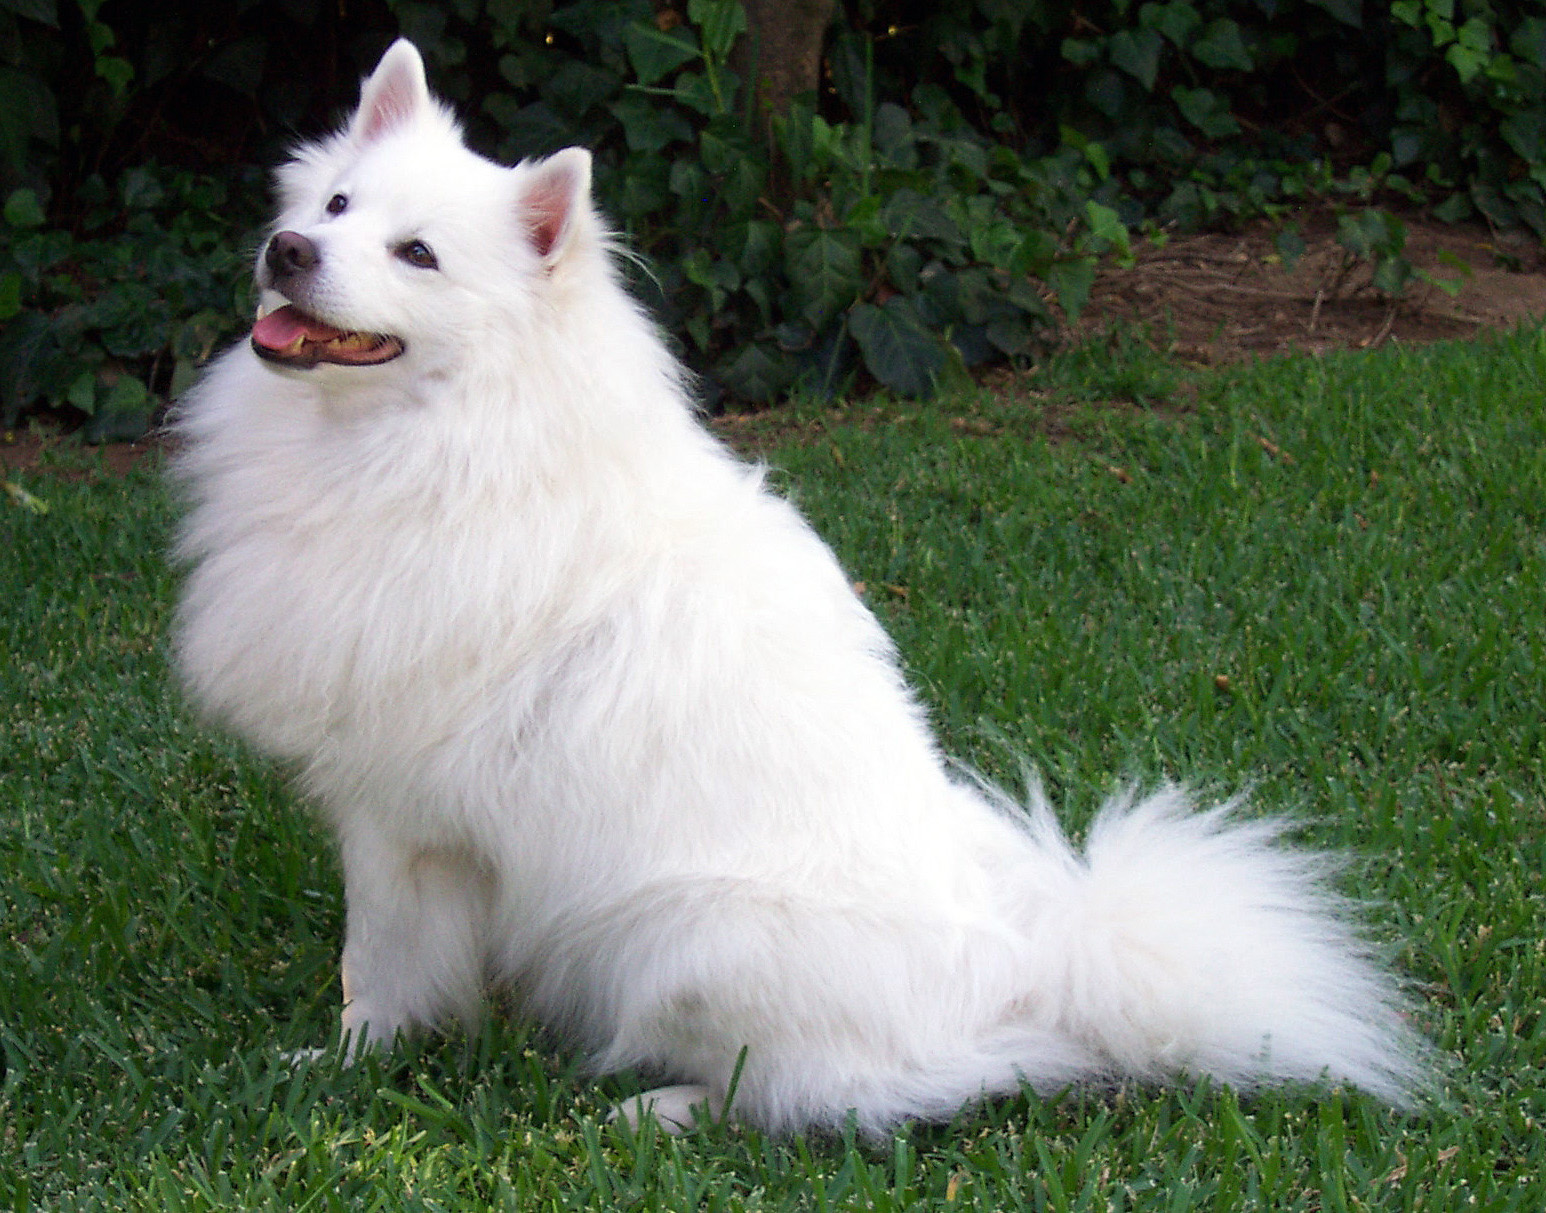

In [93]:
from IPython.display import Image, display
display(Image("dog.jpg"))

## Model Inference

### Initializing Native Torch ResNet18

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
torch_resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
torch_resnet.eval()

### Initializing Ivy ResNet18 with Pretrained Weights through Ivy Container ⬇️

The pickled weights are loaded into `Ivy ResNet` as `ivy.Container`.

In [9]:
# equivalent to ResNet18_Weights.IMAGENET1K_V1
pretrained_weights_path = "models/ivy_models/resnet/pretrained_weights/resnet_18.pickled" 

In [10]:
weights = ivy.Container.cont_from_disk_as_pickled(pretrained_weights_path) 

The model is then initialized with the Pretrained Weights 🔗.

In [91]:
# load the resnet18 model from ivy_models
from ivy_models.resnet import resnet_18 
ivy_resnet = resnet_18(v=weights) 

Compile the forward pass for efficiency. \
PS: Comment out the code below if you don't have an API key.

In [12]:
ivy.set_backend('torch')
ivy_resnet.compile(args=(img,))

### Use the model to classify your images 🚀

For comparison, both results from `Torch ResNet18` and `Ivy ResNet18` are shown below.

1. Torch ResNet18

In [90]:
torch_output = torch.softmax(torch_resnet(torch_img), dim=1)
torch_classes = torch.argsort(torch_output[0])[-4:]
torch_logits = torch.take(torch_output[0], torch_classes)

print("Indices of the top 4 classes are:", torch_classes)
print("Logits of the top 4 classes are:", torch_logits)
print("Categories of the top 4 classes are:", [categories[i] for i in torch_classes])

Indices of the top 4 classes are: tensor([257, 270, 279, 258])
Logits of the top 4 classes are: tensor([0.0074, 0.0449, 0.0530, 0.8681], grad_fn=<TakeBackward0>)
Categories of the top 4 classes are: ['Great Pyrenees', 'white wolf', 'Arctic fox', 'Samoyed']


2. Ivy ResNet18

In [92]:
output = ivy.softmax(ivy_resnet(ivy.asarray(img))["w"])  # pass the image to the model
classes = ivy.argsort(output[0])[-4:]  # get the top 4 classes
logits = ivy.gather(output[0], classes)  # get the logits

print("Indices of the top 4 classes are:", classes)
print("Logits of the top 4 classes are:", logits)
print("Categories of the top 4 classes are:", [categories[i] for i in classes.to_list()])

Indices of the top 4 classes are: ivy.array([257, 355, 222, 258])
Logits of the top 4 classes are: ivy.array([0.02254931, 0.03910801, 0.29983848, 0.60453391])
Categories of the top 4 classes are: ['Great Pyrenees', 'llama', 'kuvasz', 'Samoyed']
